### In this file the anomalies are predicted

# Imports

In [9]:
# Base imports
import os
import sys
import json
import csv 
import math
import re
#import shutil

# Mathematical libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Machine learning libraries
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score

# Plot settings
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

# Functions and Classes

### Functions

In [45]:
#================================ Plotting ========================

# Plots data with anomalies or not
def plot( df, column_names, anomalies = False, difference=False):
    # Setting figure up
    fig = plt.figure(figsize =(25, 8)) 
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    max_xticks = 10
    xloc = plt.MaxNLocator(max_xticks)
    ax.xaxis.set_major_locator(xloc)
    fig.autofmt_xdate(rotation=15)
    
    # Printing charts and anomalies
    for i, column_name in enumerate(column_names):
        ax.plot(df.index, df[column_name], label = column_name)
        if anomalies:
            if i==0:
                ax.plot(df[df["Anomaly"]==1].index, df[column_name][df["Anomaly"]==1], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="Anomalies")
            else:
                ax.plot(df[df["Anomaly"]==1].index, df[column_name][df["Anomaly"]==1], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None")
            
    ax.set_xlabel('Time steps', fontsize=30)
    ax.set_ylabel('Temperature, C', fontsize=30)
    ax.legend(fontsize=20)
    return fig

#================================ Data and directory management ========================

# Extracts settings from model name        
def extract_name_data(name):
    regex = re.compile("(?P<columns>.+)-(?P<row_length>\d+)L(?P<step_size>\d+)S(?P<test_size>\d+)T")
    groups = re.match(regex, name)
    
    columns = groups.group('columns').split('&')
    row_length = int(groups.group('row_length'))
    step_size =  int(groups.group('step_size'))
    test_size = int(groups.group('test_size'))
    
    return columns, row_length, step_size, test_size

#================================ Data processing ========================

# Prints available models and asks user to choose one and input the number
def choose_model():
    models = os.listdir(f'models/')
    models.sort()
    models.pop(0)
    print("Existing models:")
    counter = 1
    for model in models:
        print(f'{counter}) {model}')
        counter += 1
    print("\n")
    chosen_model = input("Choose model number: ")
    chosen_model = models[int(chosen_model)-1]
    print(chosen_model)
    return chosen_model

# Gets dataset name from model name
def find_dataset(model):
    dataset = model
    return dataset


# Helper function for reverse_sets
def get_batch_anomalies(Y_predicted, counter,rows_len, step,first_element, last_element):
    anomalies = np.zeros(rows_len)
    batches_considered = int(math.ceil(rows_len/step))
    if Y_predicted[counter] == 1:
        if (Y_predicted[counter-batches_considered+1:counter+1].squeeze() == np.ones(batches_considered)).all():
            anomalies[:] = 1
    anomalies = anomalies[:last_element-first_element]
    return anomalies


# Reconstructs frames into single time sequence
def reverse_sets(X, Y_predicted, step, len_test):
    
    rows_num = len(X)
    rows_len = len(X[0])
    
    values = np.zeros((rows_num*step+rows_len-step, len(X[0][0])))
    anomalies = np.zeros(rows_num*step+rows_len-step)
      
    counter = 0
    for row in X:
        if counter == rows_num:
            shift = step
        else:
            shift = rows_len
        first_element = counter*step
        last_element = counter*step + shift
        values[first_element:last_element, :] = row[:shift, :]
        anomalies[first_element:last_element] = get_batch_anomalies(Y_predicted, counter,rows_len, step, first_element, last_element)
        counter +=1
        
    values = values[-len_test:]
    anomalies = anomalies[-len_test:]
    return values, anomalies


# Choosing the model 

### Prompting user to choose the model from existent models

In [20]:
model_name = choose_model()
dataset_name = find_dataset(model_name) 

columns, row_length, step_size, test_size = extract_name_data(dataset_name)

X = np.load(f'datasets/{dataset_name}/X.npy')
original_data = np.load(f'datasets/{dataset_name}/original_data.npy', allow_pickle=True)
X_test = np.load(f'datasets/{dataset_name}/x_test.npy')
Y_test = np.load(f'datasets/{dataset_name}/y_test.npy')

Existing models:
1) B1_temp-40L20S60T


Choose model number: 1
B1_temp-40L20S60T


### Loading the model

In [21]:
path=f'Models/{model_name}'
model=load_model(path)

### Loading the relevant data set

In [22]:
columns, row_length, step_size, test_size = extract_name_data(dataset_name)

X = np.load(f'datasets/{dataset_name}/X.npy')
original_data = np.load(f'datasets/{dataset_name}/original_data.npy', allow_pickle=True)
X_test = np.load(f'datasets/{dataset_name}/x_test.npy')
Y_test = np.load(f'datasets/{dataset_name}/y_test.npy')

# Prediction

In [23]:
Y_predicted = np.round(model.predict(X_test))

# Post-processing

### Reconstructing frames or chunks of data into one continuous data set together with predictions

In [28]:
len_test = int(len(original_data)*test_size/100)
values, anomalies_pred = reverse_sets(X[-len(X_test):], Y_predicted, step_size, len_test)

60000


### Creating a relevant datafame

In [42]:
df = pd.DataFrame(original_data, columns = columns+["Anomaly_ref"])
df["Anomaly_ref"] = df["Anomaly_ref"].astype(int)
df["Anomaly_pred"] = np.nan 
df["Anomaly_pred"].iloc[-len_test:] = anomalies_pred
anomalies_ref = df["Anomaly_ref"].iloc[-len_test:].values

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Metrics

In [46]:
# Confusion matrix
cm = confusion_matrix(anomalies_ref,anomalies_pred)

# Accuracy 
accuracy = accuracy_score(anomalies_ref, anomalies_pred)

# Plotting

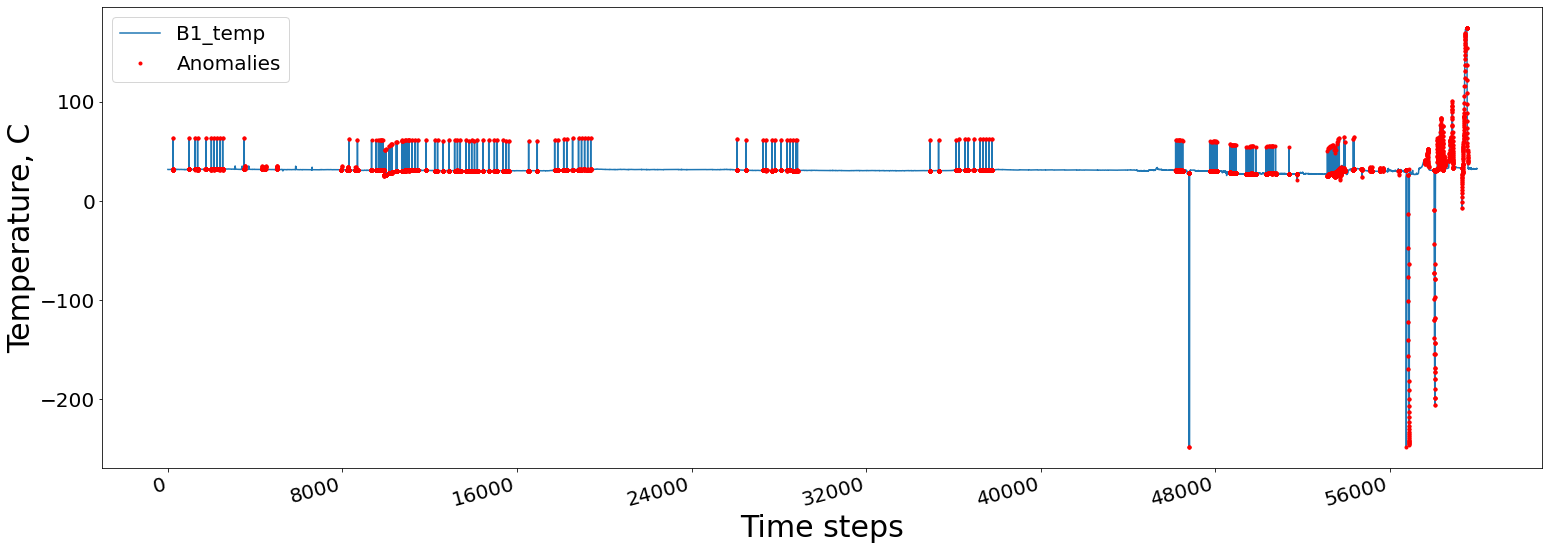

In [48]:
fig = plot(df_predicted, columns, anomalies = True)
plt.show()